In [243]:
import wandb
import yaml
from utils import correct_type_of_entry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
pd.set_option('display.max_rows', None)

In [257]:
ignore_lr = True

In [269]:
dataset = "mnist"
sweep_config = "pretraining"
values_to_fetch = ['kl_bound', 'binomial_approximation_shah', 'p2l_bound', 'compression_set_size',
                   'validation_error', 'test_error', 'CE_kl_bound', "CE_min_val_catoni_bound",
                   'complement_loss', 'validation_loss', 'test_loss']

sweep_config_name = "./configs/sweep_configs/" + sweep_config + ".yaml"
with open(sweep_config_name) as file:
    sweep_configuration = yaml.safe_load(file)
    
hps = {}
for key, item in sweep_configuration['parameters'].items():
    if item.get('values', None) is not None:
        hps[key] = correct_type_of_entry(item['values'])

if ignore_lr:
    hps['training_lr'] = [0.001, 0.0001]
size_hyperparams = tuple([len(l) for l in hps.values()])

In [270]:
api = wandb.Api()
entity = "mathieu-bazinet"
project = "sweep" + dataset
runs = api.runs(entity + "/" + project)

In [271]:
hps
# results_matrix.shape

{'seed': [1, 2, 3, 4, 42],
 'prior_size': [0.1, 0.2, 0.5],
 'pretraining_epochs': [50, 100],
 'pretraining_lr': [0.01, 0.001, 0.0001],
 'dropout_probability': [0.1, 0.2],
 'training_lr': [0.001, 0.0001]}

In [272]:
results_matrix = np.ones(((len(values_to_fetch),) + size_hyperparams))

for run_idx in range(len(runs)):
    run = runs[run_idx]
    if run.config['training_lr'] != 0.005 or not ignore_lr:
        for val_to_fetch_idx in range(len(values_to_fetch)):
            matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
            val_to_fetch = values_to_fetch[val_to_fetch_idx]
            results_matrix[matrix_idx] = run.summary[val_to_fetch]
from itertools import product

hp_list = list(hps.values())[1:]
params_product = list(product(*hp_list))
name_list = []
idx_list = []
for params in params_product:
    name = ""
    for p in params:
        name += str(p) + " "
    name_list.append(name[:-1])
    idx = ()
    for p_idx in range(len(params)):
        p_key = list(hps.keys())[1:][p_idx]
        idx += (hps[p_key].index(params[p_idx]),)
    idx_list.append(tuple(idx))

In [273]:
reshaped_matrix = results_matrix.mean(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T

mean_df = pd.DataFrame(reshaped_matrix, index=name_list, columns=values_to_fetch)
mean_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,validation_error,test_error,CE_kl_bound,CE_min_val_catoni_bound,complement_loss,validation_loss,test_loss
0.1 50 0.01 0.1 0.001,0.213968,0.213862,0.062479,2867.2,0.017674,0.017047,2.470704,2.472368,0.001082,0.081884,0.079424
0.1 50 0.01 0.1 0.0001,0.174504,0.174395,0.047146,2150.4,0.020649,0.018640,2.093709,2.101726,0.017497,0.073082,0.067387
0.1 50 0.01 0.2 0.001,0.206140,0.206034,0.059334,2720.0,0.018852,0.018028,2.390779,2.391840,0.002881,0.073749,0.069914
0.1 50 0.01 0.2 0.0001,0.186711,0.186603,0.051936,2374.4,0.025035,0.022635,2.353601,2.402747,0.051044,0.107930,0.103840
0.1 50 0.001 0.1 0.001,0.210376,0.210270,0.060976,2796.8,0.010806,0.010481,2.422313,2.421887,0.000028,0.082669,0.072908
0.1 50 0.001 0.1 0.0001,0.103742,0.103626,0.023853,1068.8,0.012763,0.011176,1.208206,1.207762,0.002082,0.053264,0.042896
0.1 50 0.001 0.2 0.001,0.204528,0.204422,0.058651,2688.0,0.010933,0.010840,2.355139,2.354851,0.000045,0.076769,0.068558
0.1 50 0.001 0.2 0.0001,0.102758,0.102642,0.023575,1056.0,0.012503,0.011103,1.201616,1.201210,0.002947,0.051053,0.041689
0.1 50 0.0001 0.1 0.001,0.248072,0.247970,0.077081,3552.0,0.011249,0.011180,2.856242,2.855783,0.000021,0.080183,0.077858
0.1 50 0.0001 0.1 0.0001,0.190714,0.190606,0.053179,2432.0,0.012836,0.012898,2.197686,2.199147,0.000244,0.066338,0.058373


In [274]:
std_matrix = results_matrix.std(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
std_df = pd.DataFrame(std_matrix, index=name_list, columns=values_to_fetch)
std_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,validation_error,test_error,CE_kl_bound,CE_min_val_catoni_bound,complement_loss,validation_loss,test_loss
0.1 50 0.01 0.1 0.001,0.013820,0.013822,0.005677,265.888999,0.002446,0.001717,0.154076,0.154285,0.001078,0.008895,0.003397
0.1 50 0.01 0.1 0.0001,0.010256,0.010257,0.003767,175.737987,0.003646,0.002529,0.092904,0.086899,0.007830,0.009918,0.009974
0.1 50 0.01 0.2 0.001,0.015196,0.015197,0.006115,286.216701,0.001199,0.000906,0.172420,0.172473,0.002211,0.004110,0.004799
0.1 50 0.01 0.2 0.0001,0.023493,0.023495,0.009066,423.755401,0.001141,0.002510,0.339182,0.365030,0.021410,0.020978,0.023398
0.1 50 0.001 0.1 0.001,0.010853,0.010854,0.004379,204.999902,0.001285,0.000946,0.124760,0.124596,0.000027,0.011542,0.005612
0.1 50 0.001 0.1 0.0001,0.006075,0.006076,0.001787,82.458232,0.001782,0.000886,0.066777,0.067063,0.000661,0.005348,0.001516
0.1 50 0.001 0.2 0.001,0.012674,0.012675,0.005080,237.749448,0.001949,0.000925,0.145594,0.145336,0.000036,0.012697,0.004663
0.1 50 0.001 0.2 0.0001,0.007271,0.007271,0.002148,99.148374,0.001817,0.000874,0.080037,0.080118,0.001242,0.005384,0.001169
0.1 50 0.0001 0.1 0.001,0.013912,0.013913,0.006274,294.678129,0.001039,0.000475,0.159996,0.159885,0.000022,0.005076,0.004875
0.1 50 0.0001 0.1 0.0001,0.005391,0.005391,0.002077,97.060806,0.001835,0.000856,0.061187,0.060147,0.000120,0.006910,0.004692


/var/folders/t7/t2tk8_dd3vsc811yh2mdwbbh0000gp/T/ipykernel_6044/1922408897.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


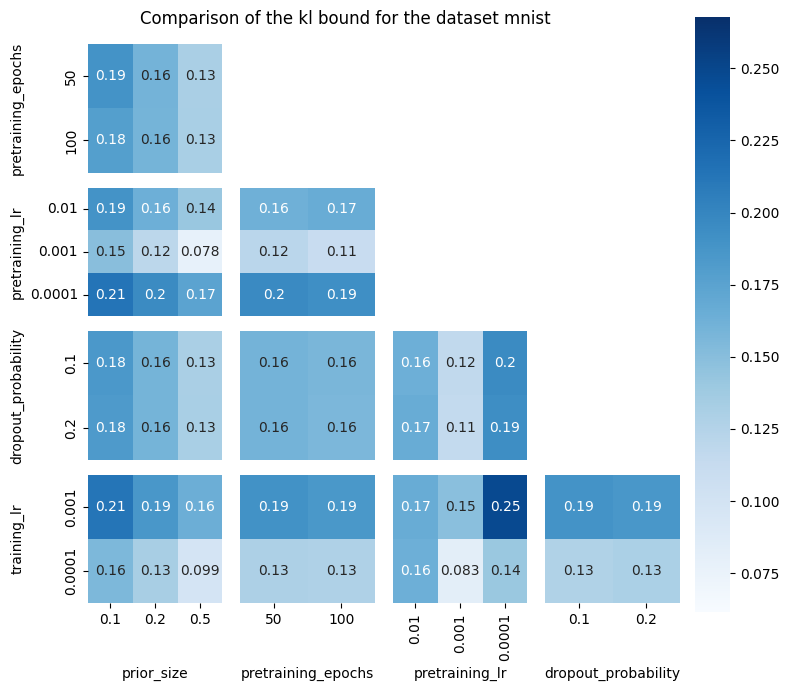

In [265]:
index = 0
mean_arr = results_matrix.mean(1)[index]
key_list = list(hps.keys())[1:]

fig, axs = plt.subplots(4, 4, figsize=(7,7))
for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)-1):
        fig.delaxes(axs[i, j])

fig.subplots_adjust(right=0.8)

cmap = 'Blues'
vmax = mean_arr.max()
vmin = mean_arr.min()

for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)):
        index_list = list(range(len(key_list)))
        index_list.remove(i)
        index_list.remove(j)
        index_list = index_list[::-1]
        new_arr = mean_arr.mean(index_list[0])
        for k in range(1,len(index_list)):
            new_arr = new_arr.mean(index_list[k])
        df = pd.DataFrame(new_arr.T, index=hps[key_list[j]], columns=hps[key_list[i]])
        if i != 0:
            yticklabels = False
        else:
            yticklabels = True
            axs[j-1,i].set(xlabel=key_list[j])
        if j+1 != len(key_list):
            xticklabels = False
        else:
            xticklabels = True
            axs[j-1,i].set(ylabel=key_list[i])
            
        if j == 1 and i == 0:
            cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])
            cbar = True
        else:
            cbar_ax = None
            cbar = False
        
        sn.heatmap(df, annot=True, ax=axs[j-1,i], cbar=cbar, vmin=vmin, vmax=vmax,
                cmap=cmap, xticklabels=xticklabels, yticklabels=yticklabels, cbar_ax=cbar_ax)
        if j+1 == len(key_list):
            axs[j-1, i].set(xlabel=key_list[i])
        if i == 0:
            axs[j-1, i].set(ylabel=key_list[j])

fig.suptitle(f"Comparison of the {values_to_fetch[index].replace("_", " ")} for the dataset {dataset}")
# # Layout so plots do not overlap
fig.tight_layout()
fig.align_labels()

plt.savefig(f"./results/mnist/{dataset}_{values_to_fetch[index]}_{"ignore_lr_" if ignore_lr else ""}heatmaps.jpg",bbox_inches='tight')

Validation error: 0.007216132991015911 KL bound 0.08882877510040998
The best bound for run 42 happens at 0 datapoints with a bound value of 0.008734955339760922
The best bound for run 4 happens at 0 datapoints with a bound value of 0.008540039550346962
The best bound for run 3 happens at 0 datapoints with a bound value of 0.015403745304398616
The best bound for run 2 happens at 0 datapoints with a bound value of 0.07677391988967727
The best bound for run 1 happens at 0 datapoints with a bound value of 0.07837818089979867
Mean value of the best bounds taken separately : 0.03756616819679649


Text(0.5, 1.0, 'Comparison of the behavior of the bound on mnist')

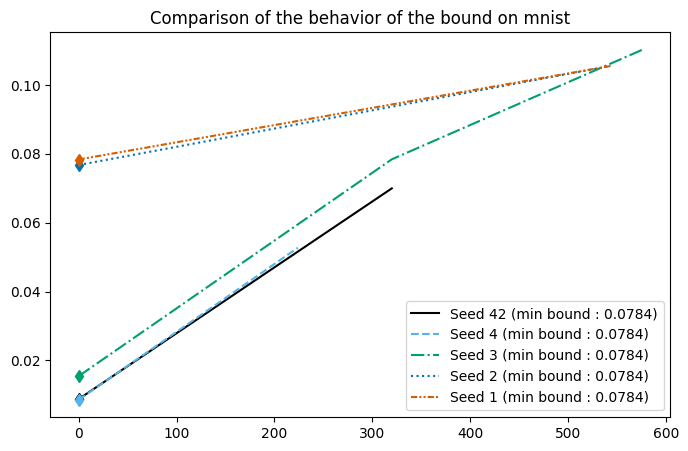

In [241]:
from bounds.real_valued_bounds import compute_epsilon, kl_bound
from copy import deepcopy

new_config = deepcopy(hps)
new_config.pop("seed", None)

best_params = correct_type_of_entry(mean_df.index[mean_df['validation_error'].argmin()].split())

print("Validation error:", mean_df['validation_error'].min(), "KL bound", mean_df.loc[mean_df.index[mean_df['validation_error'].argmin()]]['kl_bound'])
# model_type = "cnn"
# training_lr = 0.01
# dropout_probability = 0.1

# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
# linestyles = ["solid", "dotted", "dashed", "dashdot", "dashdotdotted"]
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1))]
colors = ["#000000", "#56B4E9", "#009E73", "#0072B2", "#D55E00"]

plt.figure(figsize=(8,5))
run_list = []

for run in runs:
    counter = 0
    for idx, key_item in enumerate(new_config.items()):
        key = key_item[0]
        if run.config[key] == best_params[idx]:
            counter += 1
    if counter == len(new_config.keys()):
        run_list.append(run)

all_seeds_bounds = []
max_length_run = 0
max_comp_sizes = []
counter = 0
for run in run_list:
    history = run.scan_history(keys=["kl_bound"])
    losses = [row["kl_bound"] for row in history]
    val_sizes = run.config['data_groupsize'] * run.config['log_iterations']
    compression_sizes = np.array(list(range(0,len(losses)-1))) * val_sizes
    compression_sizes = np.append(compression_sizes, run.summary['compression_set_size'])

    if compression_sizes.shape[0] > max_length_run:
        max_length_run = compression_sizes.shape[0]
        max_comp_sizes = compression_sizes
        
    plt.plot(compression_sizes, losses,'d',
             markevery=[np.array(losses).argmin()],
             linestyle=linestyles[counter], #ms=8, #mew=1.2,
             color=colors[counter],
             label=f"Seed {run.config['seed']} (min bound : {min(bound_list):.4f})")
    best_idx = np.array(losses).argmin()
    print(f"The best bound for run {run.config['seed']} happens at {compression_sizes[best_idx]} datapoints with a bound value of {losses[best_idx]}")
    all_seeds_bounds.append(losses)
    counter += 1

print(f"Mean value of the best bounds taken separately : {sum([min(l) for l in all_seeds_bounds])/5}")
plt.legend(markerscale=0)
plt.title(f"Comparison of the behavior of the bound on {dataset}")
# plt.savefig(f"./results/{dataset}_min_bound_comparison.jpg")


In [279]:
val_of_interest = "CE_kl_bound"
best_params = correct_type_of_entry(mean_df.index[mean_df[val_of_interest].argmin()].split())

best_val_arr = mean_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
std_val_arr = std_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
print(f"Validation error: {best_val_arr['validation_error']:.4f}±{std_val_arr['validation_error']:.4f} "
      f'Test error : {best_val_arr['test_error']:.4f}±{std_val_arr['test_error']:.4f} ', 
      f"KL bound : {best_val_arr['kl_bound']:.4f}±{std_val_arr['kl_bound']:.4f} ",
    f'binomial : {best_val_arr['binomial_approximation_shah']:.4f}±{std_val_arr['binomial_approximation_shah']:.4f} ',
     f'P2L bound : {best_val_arr['p2l_bound']:.4f}±{std_val_arr['p2l_bound']:.4f} ', 
      f'compression set size : {best_val_arr['compression_set_size']:.4f}±{std_val_arr['compression_set_size']:.4f} ',
f"Complement loss: {best_val_arr['complement_loss']:.4f}±{std_val_arr['complement_loss']:.4f} "
    f"Validation loss: {best_val_arr['validation_loss']:.4f}±{std_val_arr['validation_loss']:.4f} "
      f'Test loss : {best_val_arr['test_loss']:.4f}±{std_val_arr['test_loss']:.4f} ', 
    f"CE KL bound: {best_val_arr['CE_kl_bound']:.4f}±{std_val_arr['CE_kl_bound']:.4f} "
      f'CE Catoni bound : {best_val_arr['CE_min_val_catoni_bound']:.4f}±{std_val_arr['CE_min_val_catoni_bound']:.4f} ',
)

Validation error: 0.0085±0.0025 Test error : 0.0106±0.0010  KL bound : 0.0615±0.0151  binomial : 0.0613±0.0151  P2L bound : 0.0129±0.0037  compression set size : 275.2000±82.4582  Complement loss: 0.0008±0.0006 Validation loss: 0.0466±0.0113 Test loss : 0.0480±0.0073  CE KL bound: 0.7142±0.1773 CE Catoni bound : 0.7132±0.1772 
